In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

sns.set()

def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [414]:
df = pd.read_csv('df.csv')

In [415]:
df = df.reset_index()

## Some preliminary plots

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


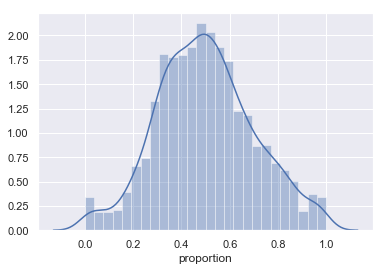

In [416]:
sns.distplot(df['proportion'])

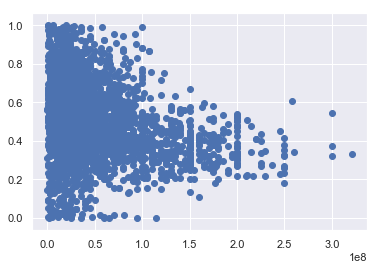

In [417]:
plt.scatter(df['budget'], df['proportion'])

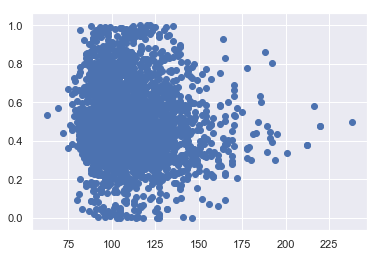

In [418]:
plt.scatter(df['runtime'], df['proportion'])

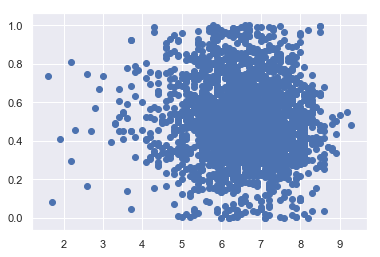

In [419]:
plt.scatter(df['user_rating'], df['proportion'])

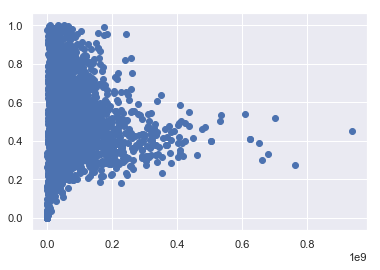

In [420]:
plt.scatter(df['usa_gross'], df['proportion'])

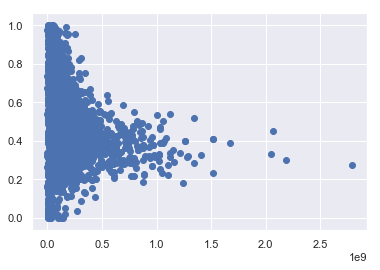

In [421]:
plt.scatter(df['cum_ww_gross'], df['proportion'])

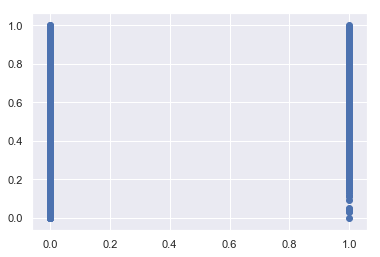

In [422]:
plt.scatter(df['Comedy'], df['proportion'])

Because I have 66 features, I was having trouble running a pairplot for all of them, so I just decided to sample a few features. These plots are a little worrying, as none of them seem to show any sort of correlation. 

In [423]:
features = df.loc[:, 'budget':'Western']

In [424]:
target = df.loc[:,'proportion']

In [425]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

m = LinearRegression()
m.fit(X_train,y_train)
m.score(X_train,y_train)

0.43557098632009605

The unregularized regression is not great, so I tried to see if regularization would help at all.

In [426]:
r = RidgeCV(cv=3)
r.fit(X_train,y_train)
r.score(X_train,y_train)

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.021690e-21
  overwrite_a=True).T
/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.044593e-21
  overwrite_a=True).T
/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.960582e-22
  overwrite_a=True).T
/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to

0.43084725568627

In [427]:
l = LassoCV()
l.fit(X_train,y_train)
l.score(X_train,y_train)

0.35470562297883146

In [428]:
e = ElasticNet()
e.fit(X_train,y_train)
e.score(X_train,y_train)

0.3678914230489192

It looks as if regularization is actually making things worse. It's possible that it's smoothing out important features in the regression.

In [429]:
poly2 = PolynomialFeatures(2)

lm_poly = LinearRegression()
lm_poly.fit(poly2.fit_transform(X_train), y_train)
lm_poly.score(poly2.fit_transform(X_train), y_train)

0.607461992366723

A 2nd-degree polynomial regression performs much better compared to the basic and regularized regressions. I decided to check how a 3rd-degree polynomial regression would perform.

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


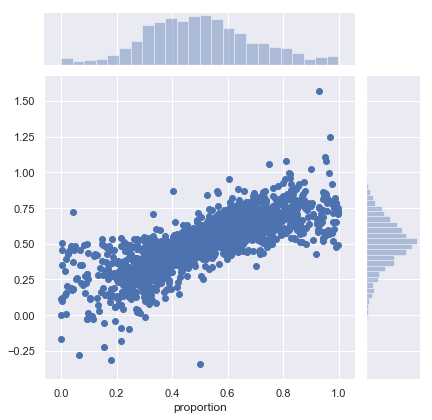

In [430]:
y_pred = lm_poly.predict(poly2.transform(X_train))
sns.jointplot(y_train, y_pred)

In [431]:
poly3 = PolynomialFeatures(3)

lm_poly = LinearRegression()
lm_poly.fit(poly3.fit_transform(X_train), y_train)
lm_poly.score(poly3.fit_transform(X_train), y_train)

0.75411273098662

/Users/madisonobrienjones/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


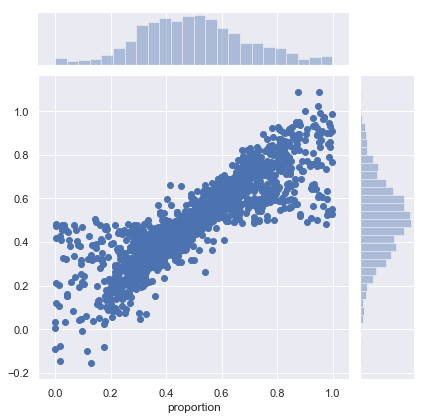

In [432]:
y_pred = lm_poly.predict(poly3.transform(X_train))
sns.jointplot(y_train, y_pred)

In [433]:
lm_poly.coef_

array([ 2.10989115e-15, -8.50453967e-17,  3.38650276e-16, ...,
        0.00000000e+00,  0.00000000e+00,  3.35372521e-28])

A 3rd-degree regression performed even better. However, there is a concern of overfitting. There is also a bit of a strange fanning-out pattern on the joint plot. I'll need to investigate this further, as well as perform some more rigorous feature selection to avoid multicolinearity. There is also a sparsity issue when it comes to the dummy variables for  country and genre. I will also need to figure out if regularization is an option down the line.  

In [434]:
numerical = ['budget', 'cum_ww_gross', 'ratings_count', 'runtime',
        'usa_gross', 'user_rating', 'year', 'proportion']

# dummy = ['Australia', 'Canada', 'China',
#        'France', 'Germany', 'Hong Kong', 'Japan', 'Spain', 'UK', 'USA',
#        'other_country', 'G', 'NC-17', 'Not Rated', 'PG', 'PG-13', 'R',
#        'Antoine Fuqua', 'Brett Ratner', 'Chris Columbus', 'Clint Eastwood',
#        'David Fincher', 'Gore Verbinski', 'Ivan Reitman', 'Joel Schumacher',
#        'M. Night Shyamalan', 'Michael Bay', 'Paul W.S. Anderson',
#        'Ridley Scott', 'Robert Zemeckis', 'Roland Emmerich', 'Ron Howard',
#        'Steven Soderbergh', 'Steven Spielberg', 'Tim Burton', 'Tony Scott',
#        'other_director', 'Action', 'Adventure', 'Animation', 'Biography',
#        'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
#        'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
#        'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

I decided to run a pairplot for just numerical features to see any relationship. There appears to be some colinearity with the variables, but not much of a clear relationship between any of them and the target variable.

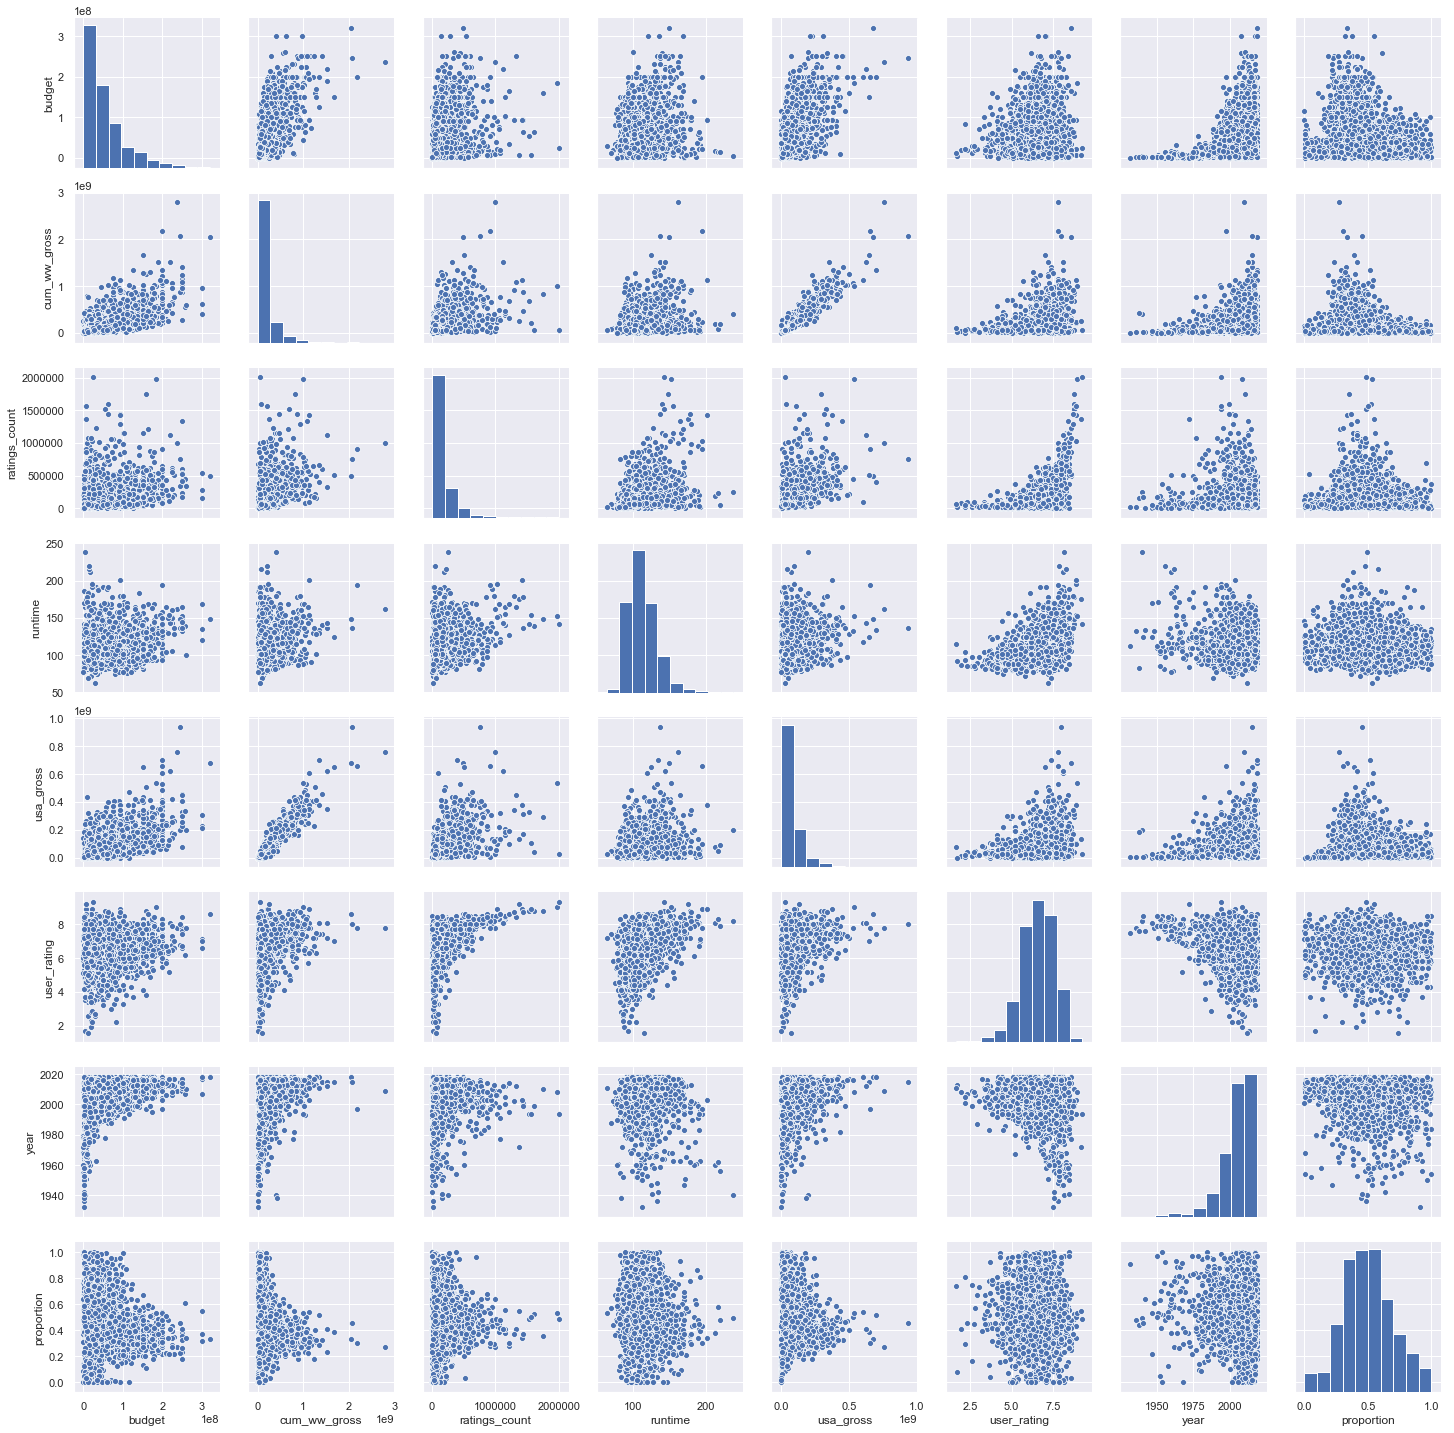

In [435]:
sns.pairplot(df[numerical])

In [436]:
df.corr()

,index,budget,cum_ww_gross,ratings_count,runtime,usa_gross,user_rating,year,Australia,Canada,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,proportion
index,1.000000,0.034835,0.012277,0.037370,0.050212,0.012139,0.027205,0.028107,-0.020713,0.039984,...,-0.002025,-0.032407,0.042172,0.023218,0.024506,0.029350,0.035491,0.004437,0.014967,0.005124
budget,0.034835,1.000000,0.688071,0.327780,0.236891,0.610659,0.020398,0.288758,-0.021526,-0.039301,...,-0.093042,-0.001280,-0.111041,-0.154855,0.210250,-0.044071,-0.093574,-0.023635,-0.000895,-0.275566
cum_ww_gross,0.012277,0.688071,1.000000,0.543225,0.246730,0.930564,0.227830,0.157900,-0.005190,-0.034777,...,-0.053178,0.039250,-0.081804,-0.106684,0.142327,-0.043783,-0.057532,-0.047070,-0.010379,-0.256346
ratings_count,0.037370,0.327780,0.543225,1.000000,0.355863,0.555341,0.533088,0.041915,-0.011689,-0.043361,...,-0.060397,-0.016473,0.019008,-0.088966,0.175207,-0.024398,0.018407,-0.004669,0.009294,-0.138204
runtime,0.050212,0.236891,0.246730,0.355863,1.000000,0.220432,0.433532,-0.147685,-0.020744,-0.047853,...,-0.018769,0.051205,-0.005329,0.025858,0.048377,0.033477,0.025389,0.119649,0.083418,-0.106571
usa_gross,0.012139,0.610659,0.930564,0.555341,0.220432,1.000000,0.238611,0.101651,-0.008349,-0.030681,...,-0.050494,0.036060,-0.079233,-0.104221,0.133173,-0.017071,-0.075909,-0.049615,-0.004797,-0.040245
user_rating,0.027205,0.020398,0.227830,0.533088,0.433532,0.238611,1.000000,-0.178955,0.003305,-0.063119,...,-0.042297,0.045746,0.018314,-0.022858,-0.016374,0.022744,0.022031,0.066180,0.035060,-0.058503
year,0.028107,0.288758,0.157900,0.041915,-0.147685,0.101651,-0.178955,1.000000,-0.007643,0.038570,...,0.006687,-0.020092,0.009158,-0.048314,0.005280,-0.004961,-0.037246,-0.062334,-0.043293,-0.170466
Australia,-0.020713,-0.021526,-0.005190,-0.011689,-0.020744,-0.008349,0.003305,-0.007643,1.000000,-0.009495,...,-0.013622,0.041318,-0.011967,0.001255,0.000293,-0.011855,-0.016783,0.024202,-0.006360,-0.035253
Canada,0.039984,-0.039301,-0.034777,-0.043361,-0.047853,-0.030681,-0.063119,0.038570,-0.009495,1.000000,...,-0.017440,-0.010223,0.062673,-0.017131,0.020593,-0.015178,0.031604,0.013436,-0.008143,-0.004847


In [437]:
# numerical = numerical[:-1]

In [438]:
# mnum = LinearRegression()
# mnum.fit(X_train[numerical],y_train)
# mnum.score(X_train[numerical],y_train)

In [439]:
# mdum = LinearRegression()
# mdum.fit(X_train[dummy],y_train)
# mdum.score(X_train[dummy],y_train)

In [440]:
# rnum = RidgeCV(cv=3)
# rnum.fit(X_train[numerical],y_train)
# rnum.score(X_train[numerical],y_train)

In [441]:
# rdum = RidgeCV(cv=3)
# rdum.fit(X_train[dummy],y_train)
# rdum.score(X_train[dummy],y_train)

In [442]:
# lnum = LassoCV()
# lnum.fit(X_train[numerical],y_train)
# lnum.score(X_train[numerical],y_train)

In [443]:
# ldum = LassoCV()
# ldum.fit(X_train[dummy],y_train)
# ldum.score(X_train[dummy],y_train)

In [444]:
# enum = ElasticNet()
# enum.fit(X_train[numerical],y_train)
# enum.score(X_train[numerical],y_train)

In [445]:
# edum = ElasticNet()
# edum.fit(X_train[dummy],y_train)
# edum.score(X_train[dummy],y_train)

In [446]:
# poly2num = PolynomialFeatures(2)

# lm_poly2num = LinearRegression()
# lm_poly2num.fit(poly2num.fit_transform(X_train[numerical]), y_train)
# lm_poly2num.score(poly2num.fit_transform(X_train[numerical]), y_train)

In [447]:
# poly2dum = PolynomialFeatures(2)

# lm_poly2dum = LinearRegression()
# lm_poly2dum.fit(poly2dum.fit_transform(X_train[dummy]), y_train)
# lm_poly2dum.score(poly2dum.fit_transform(X_train[dummy]), y_train)

In [448]:
# poly3num = PolynomialFeatures(3)

# lm_poly3num = LinearRegression()
# lm_poly3num.fit(poly3num.fit_transform(X_train[numerical]), y_train)
# lm_poly3num.score(poly3num.fit_transform(X_train[numerical]), y_train)

In [449]:
# poly3dum = PolynomialFeatures(3)

# lm_poly3dum = LinearRegression()
# lm_poly3dum.fit(poly3dum.fit_transform(X_train[dummy]), y_train)
# lm_poly3dum.score(poly3dum.fit_transform(X_train[dummy]), y_train)

When regressing only on continous variables or only on the dummy variables, the model performs worse. From this, we can infer that a mixture of these features is important to the model.

In [450]:
# poly3 = PolynomialFeatures(3)

# lasso = LassoCV(cv=3)
# lasso.fit(poly3.fit_transform(X_train), y_train)
# lasso.score(poly3.fit_transform(X_train), y_train)

In [451]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

rf = RandomForestRegressor(n_estimators=1000, max_features=8)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9321485554085598

In [452]:
rf.score(X_val, y_val)

0.5217959252673774

In [482]:
gbm = GradientBoostingRegressor(n_estimators=2000, max_depth=3, learning_rate=.2, random_state=42)
gbm.fit(X_train, y_train)
gbm.score(X_train, y_train)

0.9999945816950202

In [483]:
gbm.score(X_val, y_val)

0.9339508367965537

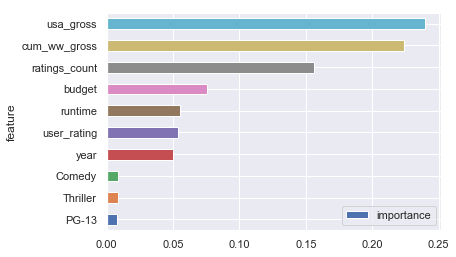

In [469]:
feat_imps = list(zip(X_train.columns,gbm.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.tail(10).plot(x='feature',y='importance',kind='barh')


In [470]:
RMSE(gbm.predict(X_val),y_val)

0.050598407098378165

In [339]:
RMSE(lm_poly.predict(poly3.fit_transform(X_train)),y_train)

0.10484299683973786

In [216]:
RMSE(lm_poly.predict(poly3.fit_transform(X_val)),y_val)

0.10082172718245448

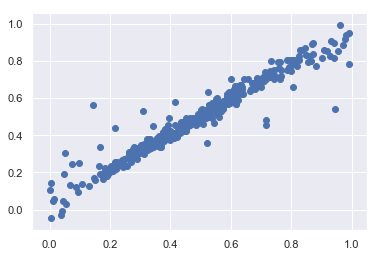

In [471]:
y_pred = gbm.predict(X_val)

plt.scatter(y_val, y_pred)

In [472]:
from sklearn import cross_validation, metrics

cv_score = cross_validation.cross_val_score(gbm, X_train, y_train, cv=5)
cv_score

array([0.92919702, 0.94398604, 0.94495587, 0.95294823, 0.95234891])

In [473]:
cv_score = cross_validation.cross_val_score(gbm, X_val, y_val, cv=5)
cv_score

array([0.79738804, 0.80358371, 0.86712581, 0.88020328, 0.85156827])

In [207]:
cv_score = cross_validation.cross_val_score(lm_poly, poly3.fit_transform(X_train), y_train, cv=5)
cv_score

array([-1.52721311e+05, -3.15729320e+01, -4.14709075e+02, -3.58564704e+02,
       -5.29561587e+01])

In [208]:
cv_score = cross_validation.cross_val_score(lm_poly, poly3.fit_transform(X_val), y_val, cv=5)
cv_score

array([-645491.98443364,   -6769.00111868, -146776.90668372,
         -1579.61306428,   -3173.8134794 ])

In [225]:
df.shape

(2581, 69)